In [1]:
from sklearn.dummy import DummyClassifier
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from typing import Type
from torch.optim import lr_scheduler
from torch.nn import Module,Linear,Sequential,ReLU,ELU,Dropout,BatchNorm1d,Flatten,CrossEntropyLoss,Conv2d,MaxPool2d
import torch, torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.autograd import Variable
from collections import OrderedDict
import timm
from timm.data import Mixup
from timm.loss import SoftTargetCrossEntropy, LabelSmoothingCrossEntropy
from typing import Tuple, Optional
from dataclasses import dataclass
import os
import sys
import random
import copy
import time
import shutil
import pickle
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
from sklearn import metrics
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from pandas import DataFrame
import seaborn as sn
import numpy as np
import PIL
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
from ipynb.fs.full._3_prepare_tracked_datasets import Char,Poly,Point,CustomUnpickler
from ipynb.fs.full._2_emnist_analyze import LeNet, Trainer
from ipynb.fs.full._9_rus_fft_angles import FNNCell
from ipynb.fs.full._7_rus_angles import CNNCell
from ipynb.fs.full._3_prepare_tracked_datasets import Char,Poly,Point,CustomUnpickler


0
None
0
None
0


/opt/jupyter_venvs/mipt_venv/lib64/python3.11/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/opt/jupyter_venvs/mipt_venv/lib64/python3.11/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/opt/jupyter_venvs/mipt_venv/lib64/python3.11/site-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/opt/jupyter_venvs/mipt_venv/lib64/python3.11/site-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/home/d.yacenko/work/Dissertation/_2_emnist_analyze.ipynb:231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is p

Классов: 76
None
Классов: 76
None


In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
BATCH_SIZE=50
EPOCHS=10
ACTIVATE="relu"
DROPOUT=True
BATCHNORM=True
TRACK_MAX_LEN_FFT=30
TRACK_MAX_LEN_ANGLES=200
CURRENT_FOLDER="./"
DATASET_VARIANT="byclass"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
f_train_dict= open(os.path.join(CURRENT_FOLDER,'train_dict_RUS.p'), 'rb')
f_test_dict= open(os.path.join(CURRENT_FOLDER,'test_dict_RUS.p'), 'rb')
TRAIN_DICT = CustomUnpickler(f_train_dict).load()
TEST_DICT = CustomUnpickler(f_test_dict).load()
f_train_dict.close()
f_test_dict.close()

In [6]:
CHAR_LIST=list(TRAIN_DICT.keys())
CHAR_LIST.sort()
print("Классов: {}".format(len(list(TRAIN_DICT.keys()))))
print(list(TRAIN_DICT.keys()).sort())
all_size=0
for key in TRAIN_DICT.keys():
  all_size+=len(TRAIN_DICT[key])

Классов: 76
None


In [7]:
all_size,TRAIN_DICT.keys()

(2245,
 dict_keys(['с', 'Ц', 'И', 'Й', 'е', '0', 'т', 'Р', 'Ь', 'к', 'ф', 'и', 'ж', 'Ж', 'ю', 'Ъ', 'щ', 'Ш', 'э', 'ъ', 'В', 'х', 'р', '4', '2', 'Т', 'ш', '8', 'з', 'а', 'л', '9', 'Е', 'П', 'я', 'О', 'М', '7', 'п', 'Г', 'у', 'м', 'Я', 'б', 'д', 'Д', '5', 'З', 'ы', 'в', 'Л', 'К', 'А', 'Б', 'Ы', 'н', 'С', '1', 'Ч', 'ч', 'Н', 'ё', 'Ю', 'о', 'Х', 'й', 'ь', '6', '3', 'Щ', 'ц', 'У', 'Ё', 'Ф', 'Э', 'г']))

Text(0, 0.5, 'количество образцов')

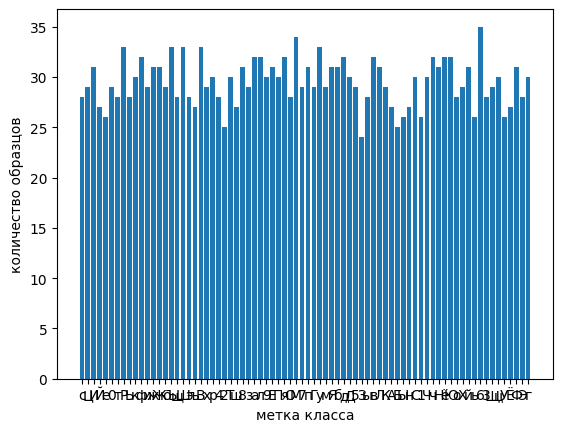

In [8]:
plt.bar( TRAIN_DICT.keys(),[len(TRAIN_DICT[key]) for key in TRAIN_DICT.keys()])
plt.xlabel("метка класса")
plt.ylabel("количество образцов")

In [9]:
class MixDataset(Dataset):

    def __init__(self, data, transform=None, data_type='fft_angles',track_max_len_fft=TRACK_MAX_LEN_FFT,track_max_len_angles=TRACK_MAX_LEN_ANGLES):
        str="0123456789АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя"
        self.type=data_type
        self.track_max_len_angles=track_max_len_angles
        self.track_max_len_fft=track_max_len_fft
        self.data=np.array([])
        for key in data.keys():
            for ch in data[key]:
                if key in str:
                    self.data=np.append(self.data,[ch])              
        self.classes=list(str)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_ix_fft = np.zeros([self.track_max_len_fft], dtype='float32')
        data_ix_angles = np.zeros([self.track_max_len_angles], dtype='float32')
        vec_angles=self.data[idx].singlePolys().angles
        vec_fft=self.data[idx].singlePolys().fft_angles
            # ограничим длинну трека
        data_ix_fft[:len(vec_fft)] = vec_fft[:self.track_max_len_fft]
        data_ix_angles[:len(vec_angles)] = vec_angles[:self.track_max_len_angles]
        img=self.data[idx].singleImage()
        array = np.array(img, dtype=np.uint8)
        img = Image.fromarray(array)
        if self.transform:
            img = self.transform(img)
        class_num=self.classes.index(self.data[idx].name)
        return torch.Tensor(data_ix_fft),torch.Tensor(data_ix_angles), img,class_num

In [10]:
vec_datasets = {"train": MixDataset(TRAIN_DICT, data_type='fft_angles', transform =transforms.ToTensor()),
                 "val":MixDataset(TEST_DICT, data_type='fft_angles',transform =transforms.ToTensor())}
dataloaders = {"train": torch.utils.data.DataLoader(vec_datasets["train"], batch_size=BATCH_SIZE,shuffle=True),
               "val": torch.utils.data.DataLoader(vec_datasets["val"] , batch_size=BATCH_SIZE,shuffle=True),
}
dataset_sizes = {x: len(vec_datasets[x]) for x in ['train', 'val']}
classes_names = {x: vec_datasets[x].classes for x in ['train', 'val']}

transform_img=transforms.Compose([lambda img: torchvision.transforms.functional.rotate(img, -90),
                                                                    transforms.RandomRotation(degrees=(-90,-90)),
                                                                    transforms.RandomHorizontalFlip(p=1),
                                                                     transforms.Resize(32),            
                                                                     ])

In [11]:
@dataclass
class CFG:
    data_dir: str = "./data"
    split: str = "byclass"       # ВАЖНО: вариант EMNIST
    num_classes: int = 76        # byclass = 62 класса
    img_size: int = 96          # Можно 96/128/160/192/224; 128 — быстрый и точный компромисс
    batch_size: int = 512        # Подберите под вашу GPU (например, 256/384/512/...)
    num_workers: int = 16
    val_ratio: float = 0.05
    epochs: int = 500             # Увеличьте до 20-40 для максимума качества
    lr: float = 5e-4             # базовый LR под AdamW (будет warmup + cosine)
    weight_decay: float = 0.05
    warmup_steps_ratio: float = 0.03  # доля шагов тренировок на линейный warmup
    min_lr_ratio: float = 0.05        # последний LR = lr * min_lr_ratio
    grad_clip_norm: float = 2.0
    label_smoothing: float = 0.07
    mixup_alpha: float = 0.2         # 0.0 = выкл; 0.2–0.4 — разумно
    cutmix_alpha: float = 0.0        # можно 0.5 совместно с mixup
    random_erasing_p: float = 0.1
    weighted_sampling: bool = False   # Включите, если замечаете дисбаланс
    ema_decay: float = 0.9997
    use_compile: bool = True
    model_name: str = "convnextv2_tiny"  # варианты: convnextv2_tiny / tf_efficientnetv2_s / resnet50d и др.
    in_chans: int = 1                  # 1 — серые изображения; timm умеет подкладывать веса из 3 каналов
    fix_emnist_orientation: bool = True
    show_samples: bool = True
cfg = CFG()

def fix_emnist(img):
    img = TF.rotate(img, 180)    # повернуть на -90 градусов
    img = TF.hflip(img)          # горизонтальное отражение
    return img

IMAGENET_GRAY_MEAN = (0.449,)
IMAGENET_GRAY_STD  = (0.226,)
transform_sota =  transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),
    transforms.Grayscale(num_output_channels=cfg.in_chans),
    transforms.Normalize(IMAGENET_GRAY_MEAN, IMAGENET_GRAY_STD),
    transforms.Lambda(fix_emnist),
])


In [12]:
tr=Trainer()
fcnet=FNNCell(track_max_len=TRACK_MAX_LEN_FFT,num_classes=len(vec_datasets["train"].classes)).to(device)
lenet = LeNet(num_classes=len(vec_datasets["train"].classes)).to(device)
cnnnet=CNNCell(num_classes=len(vec_datasets["train"].classes)).to(device)

model = timm.create_model(cfg.model_name, pretrained=True, in_chans=cfg.in_chans, num_classes=cfg.num_classes)
if device == "cuda":
    model = model.to(memory_format=torch.channels_last)
model = model.to(device)

In [13]:
fcnet.load_state_dict(torch.load("models/rus_fft_fcnet_"+DATASET_VARIANT+".pt"))
lenet.load_state_dict(torch.load("models/rus_img_fcnet_"+DATASET_VARIANT+".pt"))
cnnnet.load_state_dict(torch.load("models/rus_angles_cnnnet_"+DATASET_VARIANT+".pt"))
state = torch.load("models/best_rus_model.pth", map_location=device)

new_state = OrderedDict()
for k, v in state.items():
    nk = k
    if nk.startswith("_orig_mod."):
        nk = nk[len("_orig_mod."):]
    new_state[nk] = v
# строгая загрузка, чтобы убедиться, что всё совпадает
model.load_state_dict(new_state, strict=True)
sotanet=model

/tmp/ipykernel_9244/3463430382.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fcnet.load_state_dict(torch.load("models/rus_fft_fcnet_"+DATASET_VARIANT+".pt"))
/tmp/ipyk

In [25]:
criterion = nn.CrossEntropyLoss()
_preds_fcnet=np.array([])
_preds_cnnnet=np.array([])
_preds_lenet=np.array([])
_preds_sotanet=np.array([])
_preds_ensemble1=np.array([])
_preds_ensemble2=np.array([])
_preds_ensemble3=np.array([])
_preds_ensemble4=np.array([])
_preds_ensemble5=np.array([])
_targets=np.array([])
_loss_fcnet=0
_loss_cnnnet=0
_loss_lenet=0
_loss_sotanet=0
_loss_ensemble1=0
_loss_ensemble2=0
_loss_ensemble3=0
_loss_ensemble4=0
_loss_ensemble5=0
for tracks_fft, tracks_angles, images, labels in dataloaders['val']:    # Iterate over data.
    tracks_fft = tracks_fft.to(device)
    tracks_angles = tracks_angles.to(device)
    images = images.to(device)
    labels = labels.to(device)
    outputs_fcnet = fcnet(tracks_fft)
    outputs_cnnnet = cnnnet(tracks_angles)
    outputs_lenet = lenet(transform_img(images))
    outputs_sotanet = sotanet(transform_sota(images))
    outputs_ensemble1=(outputs_fcnet+outputs_lenet)/2
    outputs_ensemble2=(outputs_cnnnet+outputs_lenet)/2
    outputs_ensemble3=(outputs_fcnet+outputs_cnnnet+outputs_lenet)/3
    outputs_ensemble4=torch.softmax(outputs_sotanet,dim=1)
    outputs_ensemble5=(torch.softmax(outputs_fcnet/3,dim=1)+torch.softmax(outputs_cnnnet/3,dim=1)+torch.softmax(outputs_sotanet,dim=1))/3
    
    _loss_fcnet += criterion(outputs_fcnet,labels).item()*tracks_fft.size(0)
    _loss_cnnnet += criterion(outputs_cnnnet,labels).item()*tracks_angles.size(0)
    _loss_lenet += criterion(outputs_lenet,labels).item()*images.size(0)
    _loss_sotanet += criterion(outputs_sotanet,labels).item()*images.size(0)
    _loss_ensemble1 += criterion(outputs_ensemble1,labels).item()*images.size(0)
    _loss_ensemble2 += criterion(outputs_ensemble2,labels).item()*images.size(0)
    _loss_ensemble3 += criterion(outputs_ensemble3,labels).item()*images.size(0)
    _loss_ensemble4 += criterion(outputs_ensemble4,labels).item()*images.size(0)
    _loss_ensemble5 += criterion(outputs_ensemble5,labels).item()*images.size(0)
    
    _, preds_fcnet = torch.max(outputs_fcnet, 1)
    _, preds_cnnnet = torch.max(outputs_cnnnet, 1)
    _, preds_lenet = torch.max(outputs_lenet, 1)
    _, preds_sotanet = torch.max(outputs_lenet, 1)
    _, preds_ensemble1= torch.max(outputs_ensemble1, 1)
    _, preds_ensemble2= torch.max(outputs_ensemble2, 1)
    _, preds_ensemble3= torch.max(outputs_ensemble3, 1)
    _, preds_ensemble4= torch.max(outputs_ensemble4, 1)
    _, preds_ensemble5= torch.max(outputs_ensemble5, 1)
    _targets=np.append(_targets, labels.detach().cpu().numpy())
    _preds_fcnet=np.append(_preds_fcnet,preds_fcnet.detach().cpu().numpy())
    _preds_cnnnet=np.append(_preds_cnnnet,preds_cnnnet.detach().cpu().numpy())
    _preds_lenet=np.append(_preds_lenet,preds_lenet.detach().cpu().numpy())
    _preds_sotanet=np.append(_preds_sotanet,preds_sotanet.detach().cpu().numpy())
    _preds_ensemble1=np.append(_preds_ensemble1,preds_ensemble1.detach().cpu().numpy())
    _preds_ensemble2=np.append(_preds_ensemble2,preds_ensemble2.detach().cpu().numpy())
    _preds_ensemble3=np.append(_preds_ensemble3,preds_ensemble3.detach().cpu().numpy())
    _preds_ensemble4=np.append(_preds_ensemble4,preds_ensemble4.detach().cpu().numpy())
    _preds_ensemble5=np.append(_preds_ensemble5,preds_ensemble5.detach().cpu().numpy())
    

In [26]:
print("Loss по FFT траекторий: {}".format(_loss_fcnet/dataset_sizes["val"]))
print("Loss по углам траекторий: {}".format(_loss_cnnnet/dataset_sizes["val"]))
print("Loss по изображениям: {}".format(_loss_lenet/dataset_sizes["val"]))
print("Loss по ансамблю моделей (FFT+IMG): {}".format(_loss_ensemble1/dataset_sizes["val"]))
print("Loss по ансамблю моделей (ANLES+IMG): {}".format(_loss_ensemble2/dataset_sizes["val"]))
print("Loss по ансамблю моделей (FFT+ANLES+IMG): {}".format(_loss_ensemble3/dataset_sizes["val"]))
print("Loss по ансамблю моделей (SOTA): {}".format(_loss_ensemble4/dataset_sizes["val"]))
print("Loss по ансамблю моделей (FFT+ANLES+SOTA): {}".format(_loss_ensemble5/dataset_sizes["val"]))

Loss по FFT траекторий: 3.0808882931973356
Loss по углам траекторий: 1.8100894864063835
Loss по изображениям: 2.624729784287683
Loss по ансамблю моделей (FFT+IMG): 2.2614720532082586
Loss по ансамблю моделей (ANLES+IMG): 1.4958461079437686
Loss по ансамблю моделей (FFT+ANLES+IMG): 1.5134176957754442
Loss по ансамблю моделей (SOTA): 4.03493261253182
Loss по ансамблю моделей (FFT+ANLES+SOTA): 4.186416442642346


In [27]:
print("Точность предсказания по FFT траекторий: {}".format(sum(_targets==_preds_fcnet)/len(_targets)))
print("Точность предсказания по углам траекторий: {}".format(sum(_targets==_preds_cnnnet)/len(_targets)))
print("Точность предсказания по изображениям: {}".format(sum(_targets==_preds_lenet)/len(_targets)))
print("Точность предсказания по ансамблю моделей (FFT+IMG): {}".format(sum(_targets==_preds_ensemble1)/len(_targets)))
print("Точность предсказания по ансамблю моделей (ANLES+IMG): {}".format(sum(_targets==_preds_ensemble2)/len(_targets)))
print("Точность предсказания по ансамблю моделей (FFT+ANLES+IMG): {}".format(sum(_targets==_preds_ensemble3)/len(_targets)))
print("Точность предсказания по ансамблю моделей (SOTA): {}".format(sum(_targets==_preds_ensemble4)/len(_targets)))
print("Точность предсказания по ансамблю моделей (FFT+ANLES+SOTA): {}".format(sum(_targets==_preds_ensemble5)/len(_targets)))


Точность предсказания по FFT траекторий: 0.2275132275132275
Точность предсказания по углам траекторий: 0.5149911816578483
Точность предсказания по изображениям: 0.3386243386243386
Точность предсказания по ансамблю моделей (FFT+IMG): 0.4620811287477954
Точность предсказания по ансамблю моделей (ANLES+IMG): 0.6137566137566137
Точность предсказания по ансамблю моделей (FFT+ANLES+IMG): 0.6261022927689595
Точность предсказания по ансамблю моделей (SOTA): 0.6878306878306878
Точность предсказания по ансамблю моделей (FFT+ANLES+SOTA): 0.7319223985890653


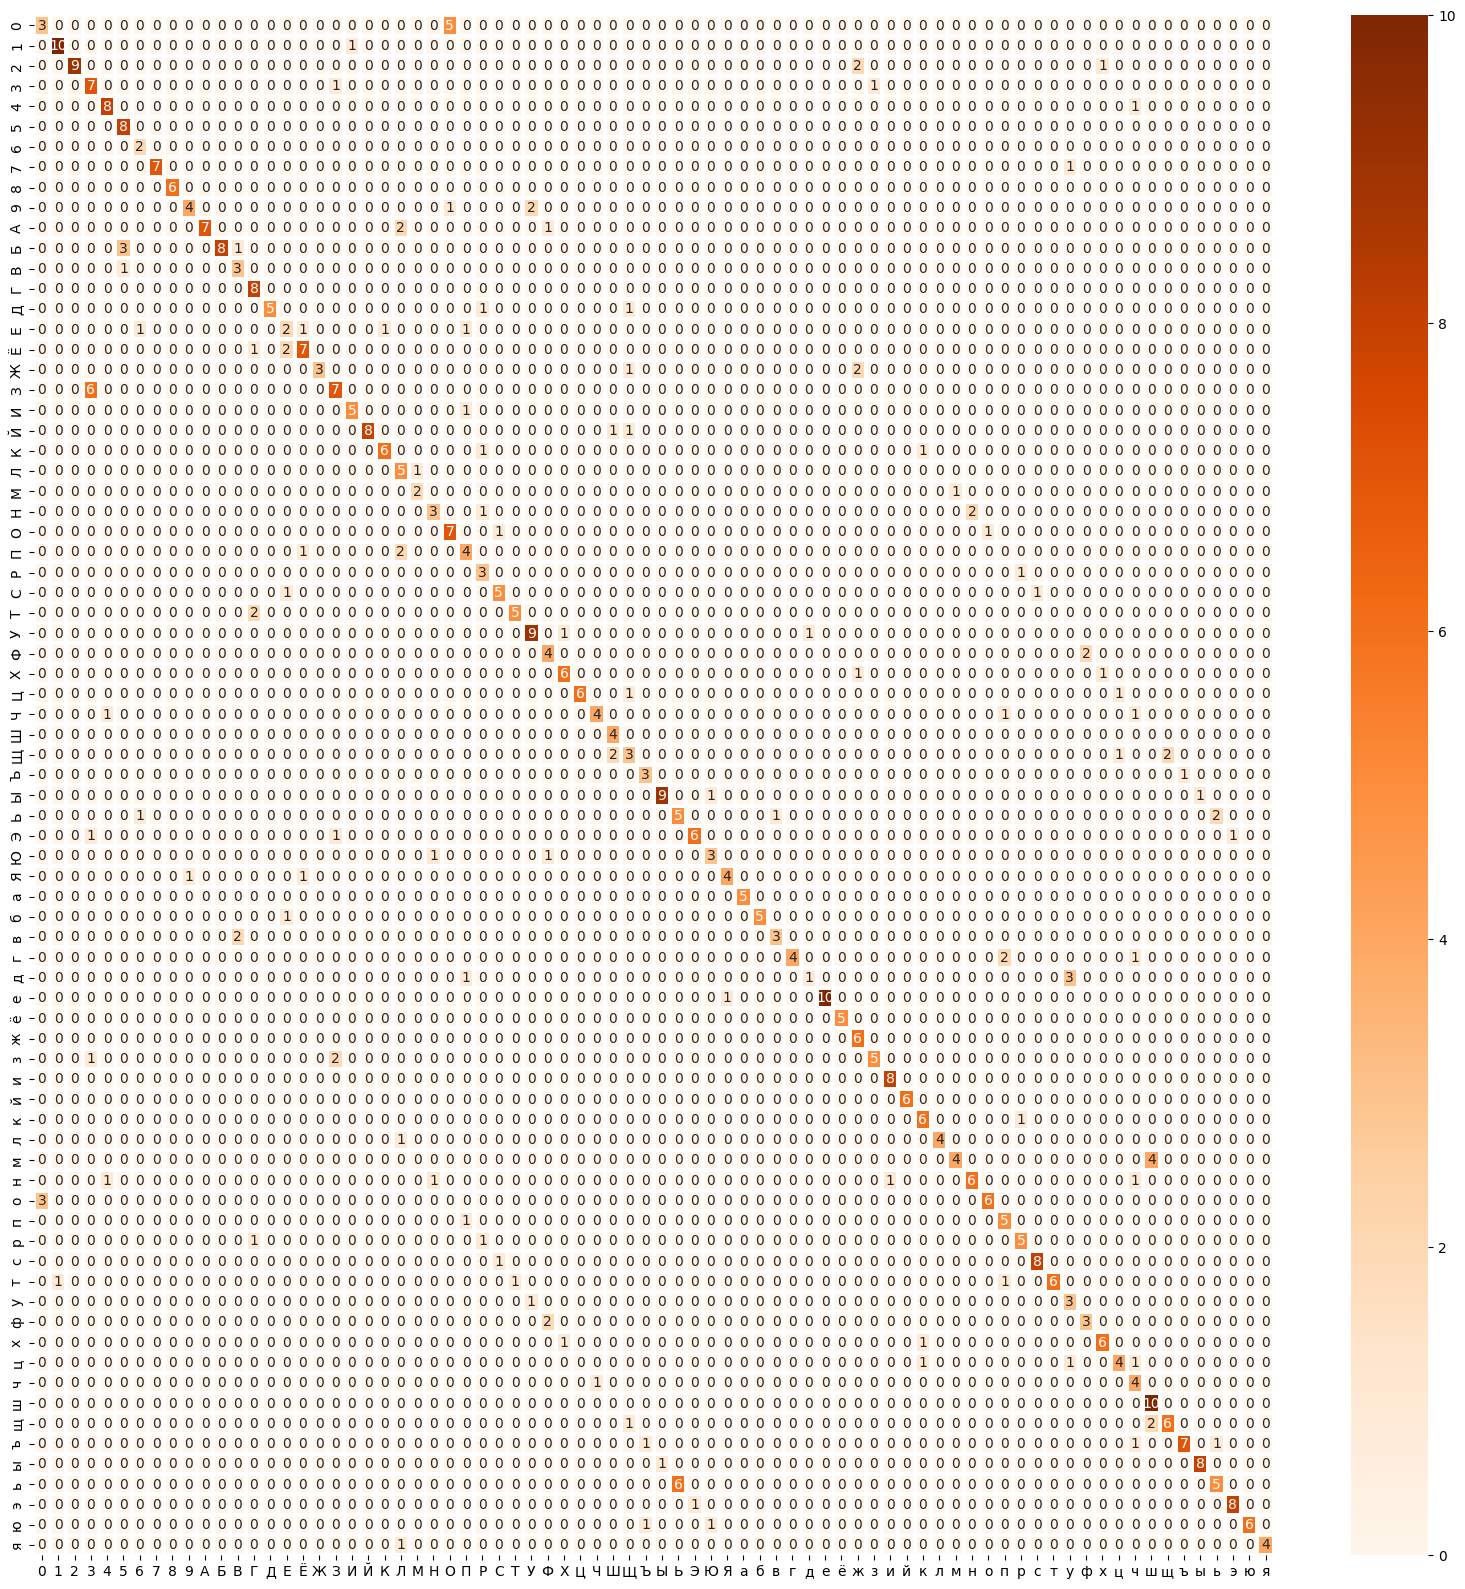

In [28]:
cm=metrics.confusion_matrix(_targets,_preds_ensemble5)
df_cm = DataFrame(cm, index=classes_names["val"], columns=classes_names["val"])
plt.subplots(figsize=(20,20))
sn.heatmap(df_cm,annot=True,  fmt="d",linewidths=1.5,cmap="Oranges",)
plt.savefig("images/Ensemble_rus_confusion_matrix.png",  bbox_inches='tight', pad_inches=0)
plt.show()